In [0]:
import re
import PIL
import pip
import nltk
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
nltk.download('wordnet')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [0]:
# Define the column names
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]

# Load the CSV file with Spark and convert it to a Pandas DataFrame
dataset = spark.read.format('csv') \
    .options(header='false', delimiter=',', inferSchema='true') \
    .load('/FileStore/tables/training_1600000_processed_noemoticon.csv') \
    .toPandas()

# Manually assign column names
dataset.columns = DATASET_COLUMNS

# Show the first few rows of the Pandas DataFrame
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int32 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 67.1+ MB


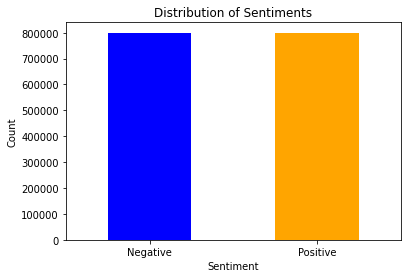

In [0]:
# Selecting only the required columns
dataset = dataset.loc[:, ['sentiment', 'text']]

# Updating sentiment values for better readability
dataset['sentiment'].replace({4: 1}, inplace=True)

sentiment_counts = dataset['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Sentiments')
plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'], rotation=0)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Converting columns into lists for further processing
text, sentiment = dataset['text'].tolist(), dataset['sentiment'].tolist()


In [0]:
text

Out[4]: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarri

In [0]:
sentiment

Out[5]: [0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [0]:
# Defining dictionary containing all emojis with their meanings
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [0]:
def cleaning(text_list):
    cleaned_texts = []
    
    # Initialize Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Define regex patterns for cleaning text
    url_regex        = r"(https?://\S+|www\.\S+)"
    mention_regex    = r"@\w+"
    special_char_regex = r"[^a-zA-Z0-9]"
    repeat_char_regex = r"(.)\1{2,}"
    repeat_replace_pattern = r"\1\1"

    for sentence in text_list:
        sentence = sentence.lower()

        # Replace URLs with 'URL'
        sentence = re.sub(url_regex, ' URL', sentence)

        # Replace mentions (@user) with 'USER'
        sentence = re.sub(mention_regex, ' USER', sentence)
        
        # Replace emojis with their respective text meanings
        for emo in emojis.keys():
            sentence = sentence.replace(emo, "EMOJI_" + emojis[emo])
        
        # Remove special characters and numbers
        sentence = re.sub(special_char_regex, " ", sentence)
        
        # Normalize repeated characters 
        sentence = re.sub(repeat_char_regex, repeat_replace_pattern, sentence)

        processed_words = []
        for word in sentence.split():
            # Apply lemmatization to each word
            if len(word) > 1:  # Ignore single-character words
                word = lemmatizer.lemmatize(word)
                processed_words.append(word)
        
        # Reconstruct the cleaned text
        cleaned_texts.append(" ".join(processed_words))
    
    return cleaned_texts


In [0]:
processedtext = cleaning(text)
print(f'Cleaning completed.')

Cleaning completed.


In [0]:
processedtext

Out[9]: ['USER URL aww that bummer you shoulda got david carr of third day to do it EMOJI wink',
 'is upset that he can update his facebook by texting it and might cry a result school today also blah',
 'USER dived many time for the ball managed to save 50 the rest go out of bound',
 'my whole body feel itchy and like it on fire',
 'USER no it not behaving at all mad why am here because can see you all over there',
 'USER not the whole crew',
 'need hug',
 'USER hey long time no see yes rain bit only bit lol fine thanks how you',
 'USER nope they didn have it',
 'USER que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ear',
 'USER couldn bear to watch it and thought the ua loss wa embarrassing',
 'USER it it count idk why did either you never talk to me anymore',
 'USER would ve been the first but didn have gun not really though zac snyder just doucheclown',
 'USER wish got to watch it with you miss you and USER how wa the premiere',
 'hollis death scene will

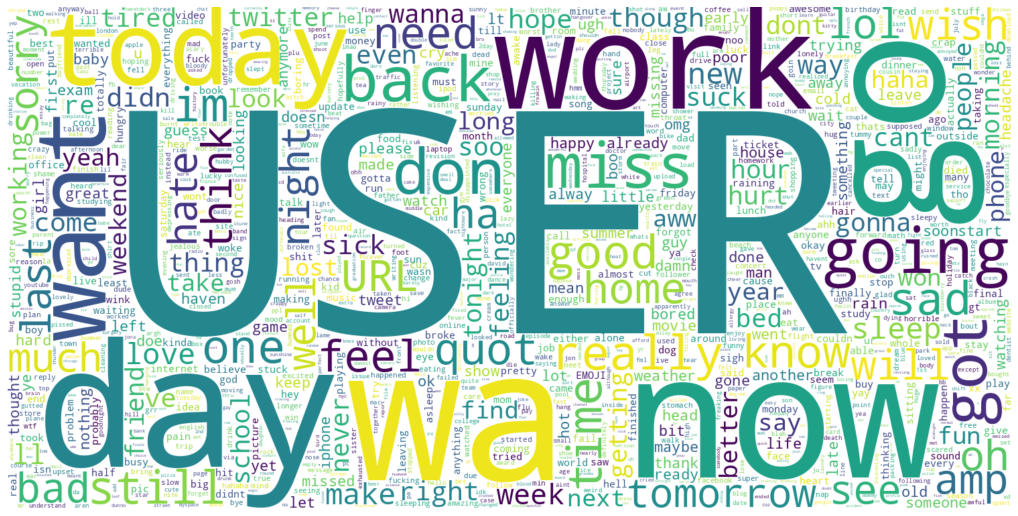

In [0]:
# Extracting the first 800,000 entries from processed text (negative sentiment)
negative_text_data = processedtext[:800000]

# Setting up the figure size for better visualization
plt.figure(figsize=(18,18))

# Generating the Word Cloud with specific parameters
wordcloud_neg = WordCloud(max_words=1200, width=1500, height=750, 
                          collocations=False, background_color="white").generate(" ".join(negative_text_data))

# Displaying the Word Cloud
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off") 
plt.show()


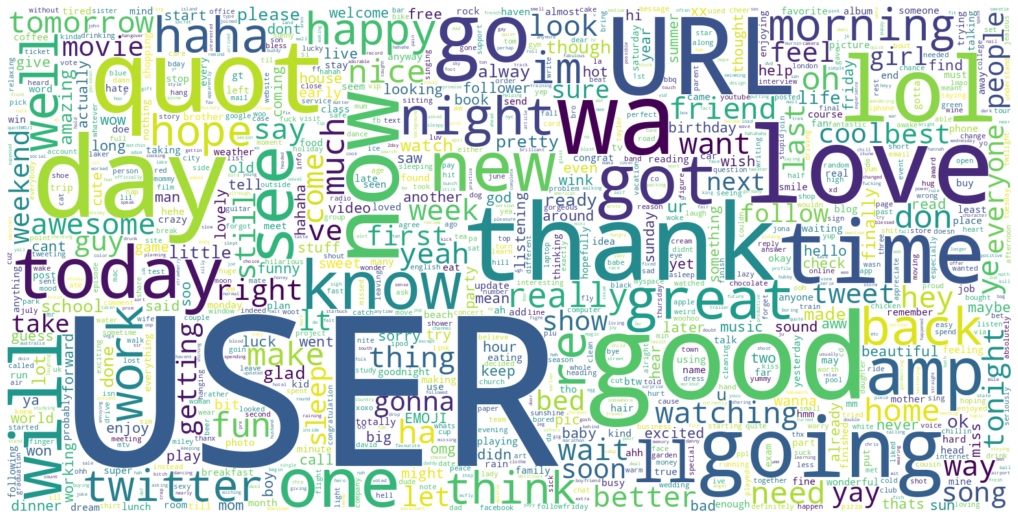

In [0]:
# Selecting the first 800,000 processed text entries for analysis (positive sentiment)
neg_text_data = processedtext[800000:]

# Define figure size for visualization
plt.figure(figsize=(18,18))

# Creating the word cloud with adjusted parameters
wordcloud_negative = WordCloud(max_words=1100, width=1550, height=780, 
                               collocations=False, background_color="white").generate(" ".join(neg_text_data))

# Display the generated word cloud
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")  # Remove axis for a cleaner look
plt.show()


In [0]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data splited Train : 80% and test: 20%.')

Data splited Train : 80% and test: 20%.


In [0]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [0]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print("Data transformation completed successfully.")

Data transformation completed successfully.


Confusion Matrix:
[[130343  29472]
 [ 26381 133804]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159815
           1       0.82      0.84      0.83    160185

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



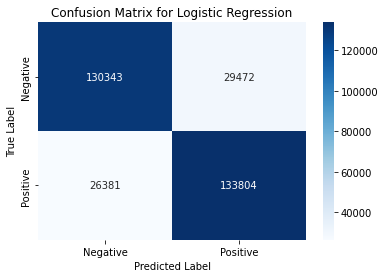

In [0]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
